In [159]:
import pandas as pd
import matplotlib.pyplot as plt

from model import LogisticRegression
from loss import LogLoss
from sklearn.model_selection import train_test_split


### Цель:
Хотим попытаться предсказать, 
есть ли у монстра особый способ передвигаться помимо обычной ходьбы, 
или же нет

In [160]:
monsters = pd.read_csv('aidedd_blocks2.csv')
monsters.columns

Index(['name', 'size', 'type', 'alignment', 'languages', 'ac', 'hp', 'cr',
       'speed', 'swim', 'fly', 'climb', 'burrow', 'passive_perception',
       'darkvision', 'truesight', 'tremorsense', 'blindsight', 'strength',
       'str_mod', 'dex', 'dex_mod', 'con', 'con_mod', 'intel', 'int_mod',
       'wis', 'wis_mod', 'cha', 'cha_mod', 'str_save', 'dex_save', 'con_save',
       'int_save', 'wis_save', 'cha_save', 'history', 'perception', 'stealth',
       'persuasion', 'insight', 'deception', 'arcana', 'religion',
       'acrobatics', 'athletics', 'intimidation', 'senses', 'attributes',
       'actions', 'legendary_actions', 'legendary', 'source'],
      dtype='object')

### Подготовка Датасета

In [161]:
monsters["special_speed"] = monsters[["swim", "fly", "climb", "burrow"]].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
monsters = monsters.drop(["speed", "swim", "fly", "climb", "burrow"], axis=1)
monsters["special_speed"].value_counts()

special_speed
0    434
1    328
Name: count, dtype: int64

In [162]:
for column in monsters:
    if ("save" in str(column)
            or "mod" in str(column)):
        monsters = monsters.drop(column, axis=1)
        continue
    if type(monsters[column][0]) is str:
        monsters[column] = pd.factorize(monsters[column])[0]
monsters = monsters.drop(['name', 'ac', 'hp', 'cr', 'legendary_actions', 'passive_perception', 'source'], axis=1)
monsters

,size,type,alignment,languages,darkvision,truesight,tremorsense,blindsight,strength,dex,...,arcana,religion,acrobatics,athletics,intimidation,senses,attributes,actions,legendary,special_speed
0,0,0,0,0,0,0,0,0,10,14,...,0,0,0,0,0,0,0,0,0,1
1,0,1,1,1,0,0,0,0,9,14,...,8,0,0,0,0,1,1,1,0,0
2,1,2,2,2,120,0,0,0,21,9,...,0,0,0,0,0,2,2,2,1,1
3,2,3,3,3,60,0,0,0,24,10,...,0,0,0,0,0,3,1,1,0,1
4,0,4,4,4,0,120,0,0,13,16,...,22,15,0,0,0,4,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,0,70,4,196,60,0,0,0,11,12,...,0,0,0,0,0,28,297,384,0,0
758,3,7,8,16,60,0,60,0,30,10,...,0,0,0,0,0,166,1,1,0,1
759,1,11,2,21,120,0,0,0,27,24,...,0,0,0,0,18,167,298,385,1,1
760,0,4,4,158,60,0,0,0,13,6,...,0,0,0,0,0,116,193,386,0,0


In [163]:
from sklearn.preprocessing import StandardScaler

train_data, test_data, train_out, test_out = train_test_split(
    monsters.drop('special_speed', axis=1),
    monsters['special_speed'],
    test_size=0.2, shuffle=True, stratify=monsters['special_speed'], random_state=42
)
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

model = LogisticRegression()
model.fit(train_data, train_out, LogLoss)

predictions = model.predict(test_data)

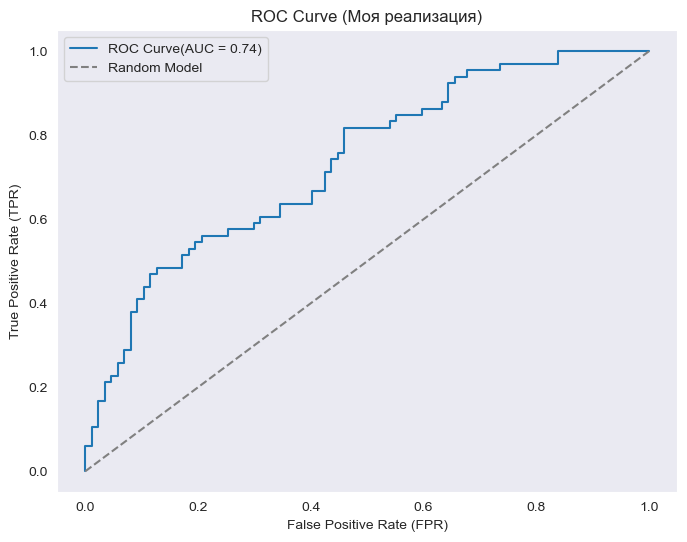

In [164]:
from metrics import roc_curve, roc_auc_score

y_score = model.predict_proba(test_data)
auc = roc_auc_score(test_out, y_score)

fpr, tpr = roc_curve(test_out, y_score)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve(AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Model')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve (Моя реализация)')
plt.legend()
plt.grid()
plt.show()

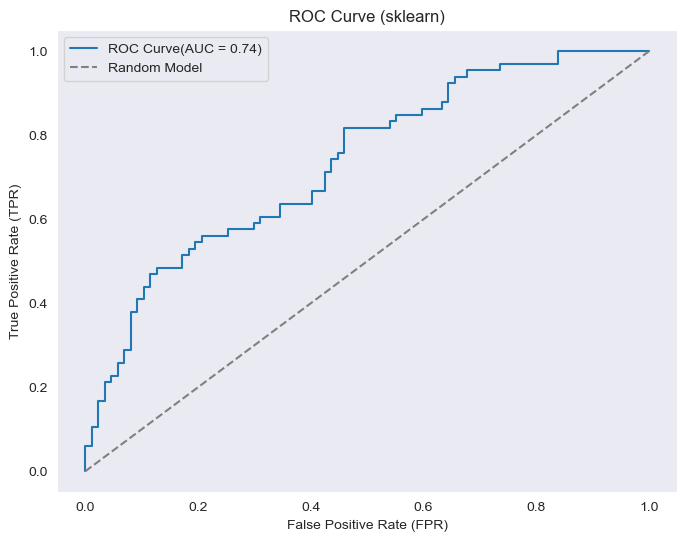

In [165]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(test_out, y_score)
auc = roc_auc_score(test_out, y_score)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve(AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Model')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve (sklearn)')
plt.legend()
plt.grid()
plt.show()

In [166]:
from metrics import accuracy, precision, recall, f1_score
acc = accuracy(test_out, predictions)
pr = precision(test_out, predictions)
rc = recall(test_out, predictions)
f1 = f1_score(test_out, predictions)
print(f'Accuracy: {acc}\nPrecision: {pr}\nRecall: {rc}\nF1: {f1}')

Accuracy: 0.6862745098039216
Precision: 0.6607142857142857
Recall: 0.5606060606060606
F1: 0.6065573770491803


In [167]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
acc = accuracy_score(test_out, predictions)
pr = precision_score(test_out, predictions)
rc = recall_score(test_out, predictions)
f1 = f1_score(test_out, predictions)
print(f'Метрики из sklearn:\nAccuracy: {acc}\nPrecision: {pr}\nRecall: {rc}\nF1: {f1}')

Метрики из sklearn:
Accuracy: 0.6862745098039216
Precision: 0.6607142857142857
Recall: 0.5606060606060606
F1: 0.6065573770491803


### Результат с L1-регуляризацией

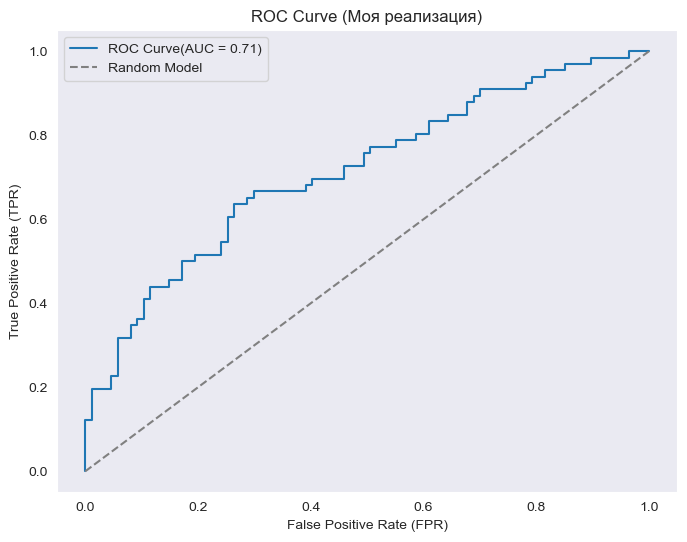

Accuracy: 0.6601307189542484
Precision: 0.6296296296296297
Recall: 0.5151515151515151
F1: 0.5666666666666667


In [170]:
from metrics import accuracy, precision, recall, f1_score, roc_curve, roc_auc_score

l1_reg_model = LogisticRegression(regularization='l1', lambda_=0.01)
l1_reg_model.fit(train_data, train_out, LogLoss)
predictions = l1_reg_model.predict(test_data)
y_score = l1_reg_model.predict_proba(test_data)
auc = roc_auc_score(test_out, y_score)

fpr, tpr = roc_curve(test_out, y_score)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve(AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Model')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve (L1 Регуляризация)')
plt.legend()
plt.grid()
plt.show()

acc = accuracy(test_out, predictions)
pr = precision(test_out, predictions)
rc = recall(test_out, predictions)
f1 = f1_score(test_out, predictions)
print(f'Accuracy: {acc}\nPrecision: {pr}\nRecall: {rc}\nF1: {f1}')

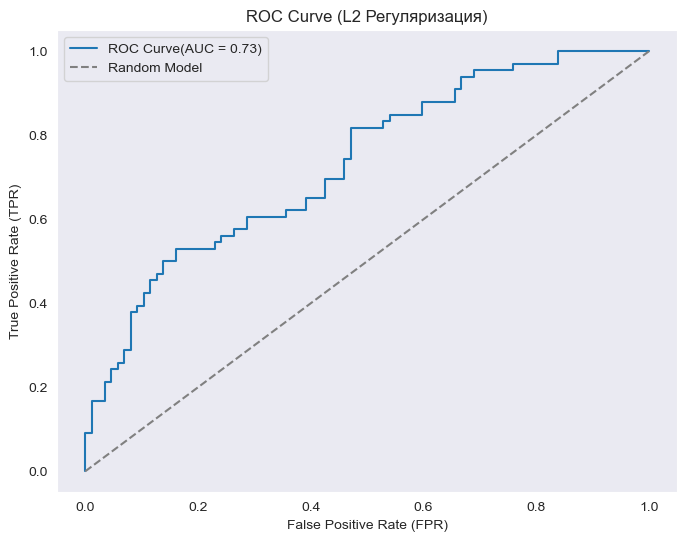

Accuracy: 0.673202614379085
Precision: 0.6481481481481481
Recall: 0.5303030303030303
F1: 0.5833333333333333


In [171]:
from metrics import accuracy, precision, recall, f1_score, roc_curve, roc_auc_score

l2_reg_model = LogisticRegression(regularization='l2', lambda_=0.01)
l2_reg_model.fit(train_data, train_out, LogLoss)
predictions = l2_reg_model.predict(test_data)
y_score = l2_reg_model.predict_proba(test_data)
auc = roc_auc_score(test_out, y_score)

fpr, tpr = roc_curve(test_out, y_score)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve(AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Model')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve (L2 Регуляризация)')
plt.legend()
plt.grid()
plt.show()

acc = accuracy(test_out, predictions)
pr = precision(test_out, predictions)
rc = recall(test_out, predictions)
f1 = f1_score(test_out, predictions)
print(f'Accuracy: {acc}\nPrecision: {pr}\nRecall: {rc}\nF1: {f1}')

#### Вывод:
Выбор Датасета и критерия для классификации получился 
не слишком удачным, однако определённый результат всё же есть 